<a href="https://colab.research.google.com/github/HWu3150/python-compiler/blob/presentation_1/Numba_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numba
from numba import njit, jit, vectorize, prange
from numba.core.compiler import CompilerBase, DefaultPassBuilder
from numba.core.compiler_machinery import FunctionPass, register_pass
from numba.core.untyped_passes import IRProcessing, ReconstructSSA
from numba.core import ir, ir_utils, config, errors

import ast
import inspect
import re
import time
from IPython.display import display
from graphviz import Digraph

import numpy as np

# **Demo: performance of using Numba vs. not using it**

In [ ]:
@njit
def sum_of_squares(arr):
    ss = 0.0
    for i in arr:
        ss += i ** 2
    return ss

arr = np.random.rand(10**4)

start = time.time()
result_python = sum(i ** 2 for i in arr)
end = time.time()
print(f"Without Numba: Result={result_python}, Time={end - start:.6f} seconds")

start = time.time()
result_numba = sum_of_squares(arr)
end = time.time()
print(f"With Numba: Result={result_numba}, Time={end - start:.6f} seconds")

start = time.time()
result_numba = sum_of_squares(arr)
end = time.time()
print(f"With Numba (second run): Result={result_numba}, Time={end - start:.6f} seconds")

Without Numba: Result=3322.899366711567, Time=0.005284 seconds
With Numba: Result=3322.899366711567, Time=1.634676 seconds
With Numba (second run): Result=3322.899366711567, Time=0.000081 seconds


#**Demo: nopython vs object mode vs fallback mode**

In [ ]:
class Person:
    def __init__(self, name, age):
        self.name = name
        self.age = age

    def future_age(self, years):
        return self.age + years

In [ ]:
@njit
def calculate_future_age():
    person = Person("Jake", 30)
    return person.future_age(10)

print(calculate_future_age()) # an error is expected

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
Untyped global name 'Person': Cannot determine Numba type of <class 'type'>

File "<ipython-input-5-41c921f84db8>", line 3:
def calculate_future_age():
    person = Person("Jake", 30)
    ^


In [ ]:
@jit(forceobj=True)
def calculate_future_age2():
    person = Person("Jake", 30)
    return person.future_age(10)

print(calculate_future_age2())

40


# **Demo: Function Vectorization**

In [ ]:
@vectorize(["float64(float64, float64)"], target="cpu")
def square_sum(x, y):
  return x**2 + y**2

arr1 = np.random.rand(10**7)
arr2 = np.random.rand(10**7)

start = time.time()
result_numpy = arr1**2 + arr2**2
end = time.time()
print(f"Without Numba: Time={end - start:.6f} seconds")

start = time.time()
result_numba = square_sum(arr1, arr2)
end = time.time()
print(f"With Numba Vectorize: Time={end - start:.6f} seconds")

start = time.time()
result_numba = square_sum(arr1, arr2)
end = time.time()
print(f"With Numba Vectorize (second run): Time={end - start:.6f} seconds")

print(f"Check results: {np.allclose(result_numpy, result_numba)}")

Without Numba: Time=0.090259 seconds
With Numba Vectorize: Time=0.031538 seconds
With Numba Vectorize (second run): Time=0.042275 seconds
Check results: True


# **Demo: Create customized compiler pass and customized compiler**

In [ ]:
@register_pass(mutates_CFG=False, analysis_only=True)
class Test(FunctionPass):
  _name = "Test"

  def __init__(self):
    FunctionPass.__init__(self)

  def run_pass(self, state):
    return False

class TestCompiler(CompilerBase):

  def define_pipelines(self):
    pm = DefaultPassBuilder.define_nopython_pipeline(self.state)
    pm.add_pass_after(Test, IRProcessing)
    pm.finalize()

    print("Pipeline passes in PassManager:")
    for i, (pass_cls, _) in enumerate(pm.passes):
        print(f"{i + 1}. {pass_cls._name}")
    return [pm]

In [ ]:
@njit(pipeline_class=TestCompiler)
def test():
  x = 5
  a = 10
  if x < 10:
    a = a * 2
  else:
    a = a / 2
  return a

In [ ]:
x = test()

Pipeline passes in PassManager:
1. translate_bytecode
2. fixup_args
3. ir_processing
4. Test
5. with_lifting
6. inline_closure_likes
7. rewrite_semantic_constants
8. dead_branch_prune
9. generic_rewrites
10. Rewrite dynamic raises
11. make_function_op_code_to_jit_function
12. inline_inlinables
13. dead_branch_prune
14. find_literally
15. literal_unroll
16. reconstruct_ssa
17. LiteralPropagation
18. nopython_type_inference
19. strip_phis
20. inline_overloads
21. nopython_rewrites
22. nopython_supported_feature_validation
23. ir_legalization
24. annotate_types
25. native_lowering
26. nopython_backend
27. dump_parfor_diagnostics


In [ ]:
def get_rhs_vars(stmt):
    var_list = []
    if isinstance(stmt, ir.Assign):
        if not isinstance(stmt.value, ir.Const):
            if isinstance(stmt.value, ir.Expr):
                # get list of vars from the Expr
                expr_vars = ir.Expr.list_vars(stmt.value)
                for var in expr_vars:
                    var_list.append(var.name)
            else:
                var_list.append(stmt.value.name)
    elif isinstance(stmt, ir.Return):
        var_list.append(stmt.value.name)
    elif isinstance(stmt, ir.Expr):
        var_list.append(ir.Expr.list_vars(stmt))
    else:
        raise ValueError("Unexpected statement type: {}".format(type(stmt)))
    return var_list


def get_lhs_vars(stmt):
    if isinstance(stmt, ir.Assign):
        return stmt.target
    elif isinstance(stmt, ir.Return):
        return stmt.value
    elif isinstance(stmt, ir.Expr):
        return stmt
    else:
        raise ValueError("Unexpected statement type: {}".format(type(stmt)))


@register_pass(mutates_CFG=False, analysis_only=False)
class PrintAssignments(FunctionPass):
    _name = "dead_code_elimination1"

    def __init__(self):
        FunctionPass.__init__(self)

    def run_pass(self, state):
        # state contains the FunctionIR to be mutated,
        mutate = True
        new_len, cur_len = 0, 0
        func_ir = state.func_ir
        vars = ir_utils.get_name_var_table(func_ir.blocks)

        for blk in func_ir.blocks.values():
            cur_len = len(blk.body)
            while cur_len != new_len:
                used_vars = []
                cur_len = len(blk.body)
                for stmt in blk.body:
                    # print(stmt)
                    used_vars.append(get_rhs_vars(stmt))
                used_vars = [item for sublist in used_vars for item in sublist]

                new_body = []
                # iterate over each statement in the block
                for stmt in blk.body:
                    target_var = get_lhs_vars(stmt)
                    if target_var.name not in used_vars:
                        mutate = True  # the pass will mutate the IR
                        continue  # skip this statement
                    new_body.append(stmt)  # keep this statement
                    print(stmt)
                blk.body = new_body  # update the block with new statements
                new_len = len(blk.body)
                print()
        return mutate  # the pass has not mutated the IR


class MyCompiler(CompilerBase):  # custom compiler extends from CompilerBase

    def define_pipelines(self):
        pm = DefaultPassBuilder.define_nopython_pipeline(self.state)
        #pm.add_pass_after(PrintAssignments, IRProcessing)
        pm.add_pass_after(PrintAssignments, ReconstructSSA)
        pm.finalize()
        return [pm]


@njit(pipeline_class=MyCompiler)
def dce_test():
    a = 10
    b = 20
    c = 40
    d = c + a
    e = d + b
    c = a + b
    return c


# test SpMV csr
# generate a random sparse matrix CSR format
print(numba.__version__, "\n")
c = dce_test()
print(c)

0.60.0 

a = const(int, 10)
b = const(int, 20)
c = const(int, 40)
d = c + a
c.1 = a + b
$40return_value.13 = cast(value=c.1)
return $40return_value.13

a = const(int, 10)
b = const(int, 20)
c = const(int, 40)
c.1 = a + b
$40return_value.13 = cast(value=c.1)
return $40return_value.13

a = const(int, 10)
b = const(int, 20)
c.1 = a + b
$40return_value.13 = cast(value=c.1)
return $40return_value.13

a = const(int, 10)
b = const(int, 20)
c.1 = a + b
$40return_value.13 = cast(value=c.1)
return $40return_value.13

30


# **Final demo: Numba SSA to Python AST**

In [112]:
# Compiler pass that gets and stores Numba SSA statements
ssa_statements = []

@register_pass(mutates_CFG=False, analysis_only=True)
class GetSSAPass(FunctionPass):
  _name = "get_ssa"

  def __init__(self):
    FunctionPass.__init__(self)

  def run_pass(self, state):
    for blk in state.func_ir.blocks.values():
      for stmt in blk.body:
        ssa_statements.append(stmt)
    return False # analysis only

class GetSSACompiler(CompilerBase):

  def define_pipelines(self):
    pm = DefaultPassBuilder.define_nopython_pipeline(self.state)
    pm.add_pass_after(GetSSAPass, ReconstructSSA)
    pm.finalize()
    return [pm]

In [ ]:
# Retrieve AST of a function
# Then visualize it using Graphviz

In [128]:
# get Python AST of a given function
def get_ast(func):
    source = inspect.getsource(func)
    tree = ast.parse(source)
    print("AST Tree:", ast.dump(tree, indent=4))
    return tree

# visualize Python AST
def visualize_ast(node, graph=None, parent=None):
  if graph is None:
    graph = Digraph(comment="AST")

  # contex of the node, for example, Store(), Load()
  node.ctx = None

  node_id = str(id(node))
  label = type(node).__name__

  # set node name
  if isinstance(node, ast.Constant):
    label += f"\\n{node.value}"
  elif isinstance(node, ast.Name):
    label += f"\\n{node.id}"
  elif isinstance(node, ast.BinOp):
    label += f"\\n{type(node.op).__name__}"

  graph.node(node_id, label)

  # draw an edge between current node and its parent node
  if parent is not None:
    graph.edge(parent, node_id)

  # recursively draw childs of current node (draw subtrees)
  for child_name, child in ast.iter_fields(node):
    if isinstance(child, ast.AST):
      visualize_ast(child, graph, node_id)
    elif isinstance(child, list):
      for item in child:
        if isinstance(item, ast.AST):
          visualize_ast(item, graph, node_id)

  return graph

def test_ast_loop():
  x = 0
  for i in range(0, 5):
    x += i
  return x

In [129]:
@njit(pipeline_class=GetSSACompiler)
def test_ast():
  a = 10
  a = a + 10
  c = a * 2
  return c

AST Tree: Module(
    body=[
        FunctionDef(
            name='test_ast',
            args=arguments(
                posonlyargs=[],
                args=[],
                kwonlyargs=[],
                kw_defaults=[],
                defaults=[]),
            body=[
                Assign(
                    targets=[
                        Name(id='a', ctx=Store())],
                    value=Constant(value=10)),
                Assign(
                    targets=[
                        Name(id='a', ctx=Store())],
                    value=BinOp(
                        left=Name(id='a', ctx=Load()),
                        op=Add(),
                        right=Constant(value=10))),
                Assign(
                    targets=[
                        Name(id='c', ctx=Store())],
                    value=BinOp(
                        left=Name(id='a', ctx=Load()),
                        op=Mult(),
                        right=Constant(value=2))),
           

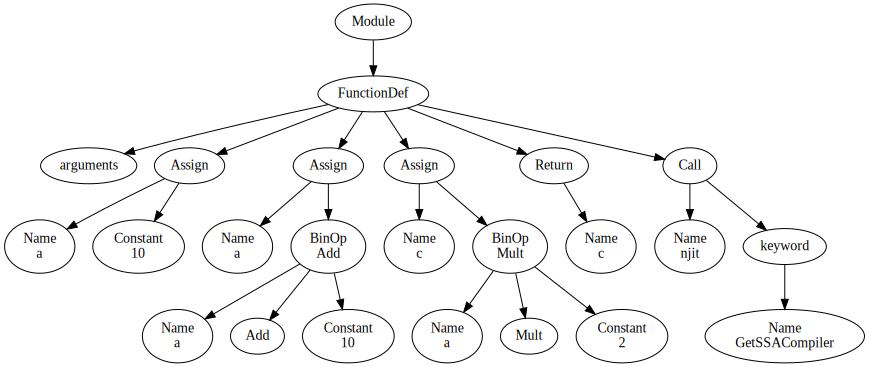

In [130]:
ssa_statements = []
func_ast = get_ast(test_ast)
ast_viz = visualize_ast(func_ast)
#ast.render("AST Visualization", format="png", view=True)
display(ast_viz)

In [132]:
# Mapping from Numba SSA operation to Python AST node
op_map = {
    'add': ast.Add,
    'sub': ast.Sub,
    'mul': ast.Mult,
    'div': ast.Div
}

'''
Convert Numba SSA to Python AST
'''
def ssa_to_ast(ssa_statements, func):
  expr_dict = {}          # stores rhs expressions
  const_dict = {}         # stores intermediate variables used to store constants
  assign_targets = set()  # prevent substituting variables by its assignment statement
  var_map = {}            # mapping between original variable and its SSAs
  func_body = []

  # get function name and args
  func_name = func.__name__
  args = [arg.name for arg in inspect.signature(func).parameters.values()]

  # In this demo, I only considered the cases that an expression is either
  # a variable assignment or a return statement
  for stmt in ssa_statements:
    if isinstance(stmt, ir.Assign):
      target_name = stmt.target.name

      # store intermidate constant variables created by SSA
      if target_name.startswith('$'):
        const_dict[target_name] = stmt.value.value
        continue

      # store mapping between SSA version names and base names
      base_name = re.sub(r'\.\d+$', '', target_name)
      var_map[target_name] = base_name

      # store rhs of the expression
      expr_dict[target_name] = stmt.value

      # create an Assign AST node
      target_node = ast.Name(id=var_map.get(target_name, target_name), ctx=ast.Store())
      value_node = build_ast(target_name, expr_dict, const_dict, var_map, assign_targets)
      assign_node = ast.Assign(targets=[target_node], value=value_node)
      func_body.append(assign_node)

      assign_targets.add(target_name)

    elif isinstance(stmt, ir.Return):
      return_node = None
      if stmt.value.name in const_dict:             # returning a variable
        tmp_name = const_dict[stmt.value.name].name # if returning a intermediate constant variable
        if tmp_name in var_map:                     # find its original form, then check if the original form is an SSA
          return_var_node = ast.Name(id=var_map[tmp_name], ctx=ast.Load())
          return_node = ast.Return(value=return_var_node)
        else:
          return_var_node = ast.Name(id=tmp_name, ctx=ast.Load())
          return_node = ast.Return(value=return_var_node)
      else: # returning an expression
        return_expr = stmt.value.name
        return_node = ast.Return(value=build_ast(return_expr, expr_dict, const_dict, var_map, assign_targets))

      func_body.append(return_node)

  # Add function parameters
  arg_nodes = [ast.arg(arg=arg, annotation=None) for arg in args]
  args_node = ast.arguments(
      posonlyargs=[], args=arg_nodes, vararg=None, kwonlyargs=[],
      kw_defaults=[], kwarg=None, defaults=[]
  )

  # Build function definition node
  func_def_node = ast.FunctionDef(
      name=func_name,
      args=args_node,
      body=func_body,
      decorator_list=[]
  )

  return ast.Module(body=[func_def_node], type_ignores=[])


'''
recrusively reconstruct AST
'''
def build_ast(target_name, expr_dict, const_dict, var_map, assign_targets):
  if target_name in const_dict and target_name.startswith('$'):
    return ast.Constant(value=const_dict[target_name])

  expr = expr_dict[target_name]
  # print('new run')
  # print('assign targets:', assign_targets)
  # print(target_name, const_dict)
  # print('expression:', expr)

  if isinstance(expr, ir.Const):
    if target_name in assign_targets:
      return ast.Name(id=target_name, ctx=ast.Load())
    return ast.Constant(value=expr.value)

  elif isinstance(expr, ir.Var):
    return ast.Name(id=var_map[expr.Name], ctx=ast.Load())

  # if the expression contains another expression, recursively build the AST
  elif isinstance(expr, ir.Expr):
    if target_name in assign_targets:
      return ast.Name(id=target_name, ctx=ast.Load())

    if expr.op == 'cast':
      return None

    left_node = build_ast(var_map.get(expr.lhs.name, expr.lhs.name), expr_dict, const_dict, var_map, assign_targets)
    right_node = build_ast(var_map.get(expr.rhs.name, expr.rhs.name), expr_dict, const_dict, var_map, assign_targets)
    op_node = op_map[expr.fn.__name__]()  # binary ops are encapsulated as Python fn
    return ast.BinOp(left=left_node, op=op_node, right=right_node)

  else:
    raise ValueError(f"Unsupported expression type: {type(expr)}")

Numba SSA:
a = const(int, 10)
$const8.2 = const(int, 10)
a.1 = a + $const8.2
$const16.5 = const(int, 2)
c = a.1 * $const16.5
$24return_value.8 = cast(value=c)
return $24return_value.8



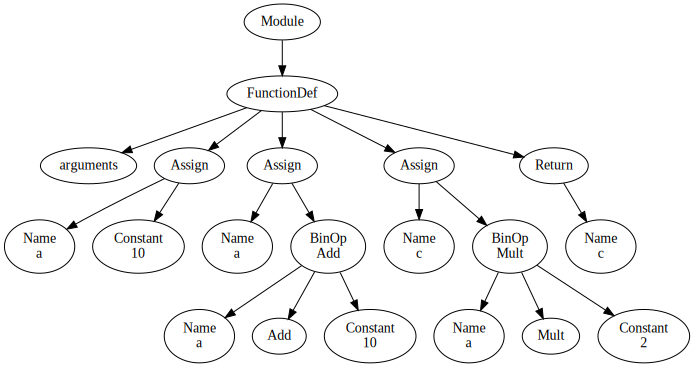

In [133]:
test_ast()
print('Numba SSA:')
for stmt in ssa_statements:
   print(stmt)
print()
# print(ssa_statements[4].value.lhs.name)
# print()
# for stmt in ssa_statements:
#   if isinstance(stmt.value, ir.Expr):
#     print(stmt.value)
#     print("rhs:", stmt.value.fn.__name__)
ast_from_ssa = ssa_to_ast(ssa_statements, test_ast)
ast_from_ssa_viz = visualize_ast(ast_from_ssa)
display(ast_from_ssa_viz)

# **Testing SSA to AST for another function**

In [134]:
@njit(pipeline_class=GetSSACompiler)
def dce_test():
    a = 10
    b = 20
    c = 40
    d = c + a
    e = d + b
    c = a + b
    return c

AST Tree: Module(
    body=[
        FunctionDef(
            name='dce_test',
            args=arguments(
                posonlyargs=[],
                args=[],
                kwonlyargs=[],
                kw_defaults=[],
                defaults=[]),
            body=[
                Assign(
                    targets=[
                        Name(id='a', ctx=Store())],
                    value=Constant(value=10)),
                Assign(
                    targets=[
                        Name(id='b', ctx=Store())],
                    value=Constant(value=20)),
                Assign(
                    targets=[
                        Name(id='c', ctx=Store())],
                    value=Constant(value=40)),
                Assign(
                    targets=[
                        Name(id='d', ctx=Store())],
                    value=BinOp(
                        left=Name(id='c', ctx=Load()),
                        op=Add(),
                        right=Name(id

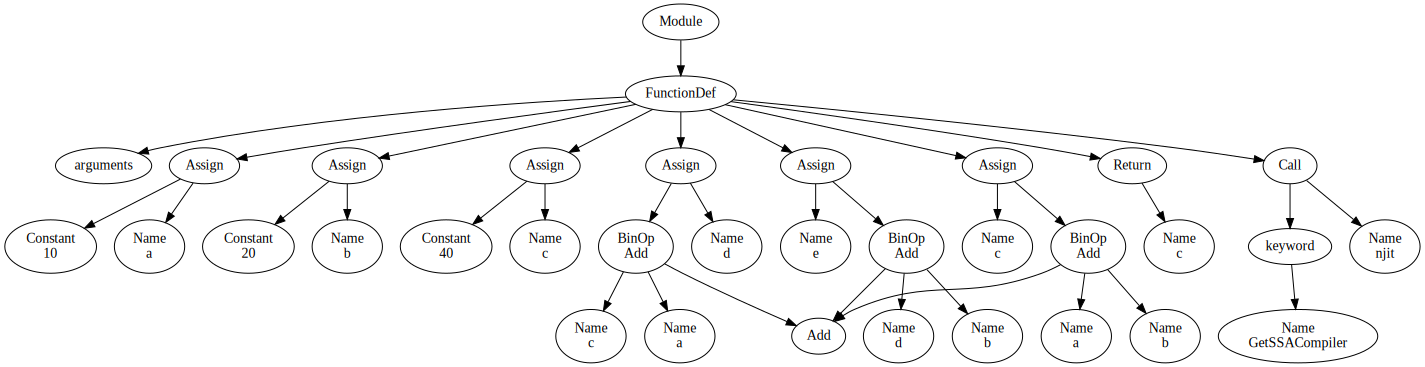

In [135]:
ssa_statements = []
dce_test()
func_ast = get_ast(dce_test)
ast_viz = visualize_ast(func_ast)
#ast.render("AST Visualization", format="png", view=True)
display(ast_viz)

In [110]:
# the above plot has a single Add node being connected from several BinOp nodes
# this occurs because Python AST is internally reusing unimportant nodes, such
# as operator nodes that don't store extra information
# the following code snippet shows that Python AST is reusing nodes

# code from dce_test()
code = """
a = 10
b = 20
c = 40
d = c + a
e = d + b
c = a + b
return c
"""

tree = ast.parse(code)

# Collect ids of all operator nodes
operator_ids = []
for node in ast.walk(tree):
    if isinstance(node, ast.BinOp):
        operator_ids.append((node.op, id(node.op)))

# Print operator type and id
for op, op_id in operator_ids:
    print(f"Operator: {type(op).__name__}, ID: {op_id}")

# Check if any IDs are duplicated
unique_ids = {op_id for _, op_id in operator_ids}
if len(unique_ids) < len(operator_ids):
    print("AST is reusing operator nodes.")
else:
    print("AST is not reusing operator nodes.")

Operator: Add, ID: 138746686162064
Operator: Add, ID: 138746686162064
Operator: Add, ID: 138746686162064
AST is reusing operator nodes.


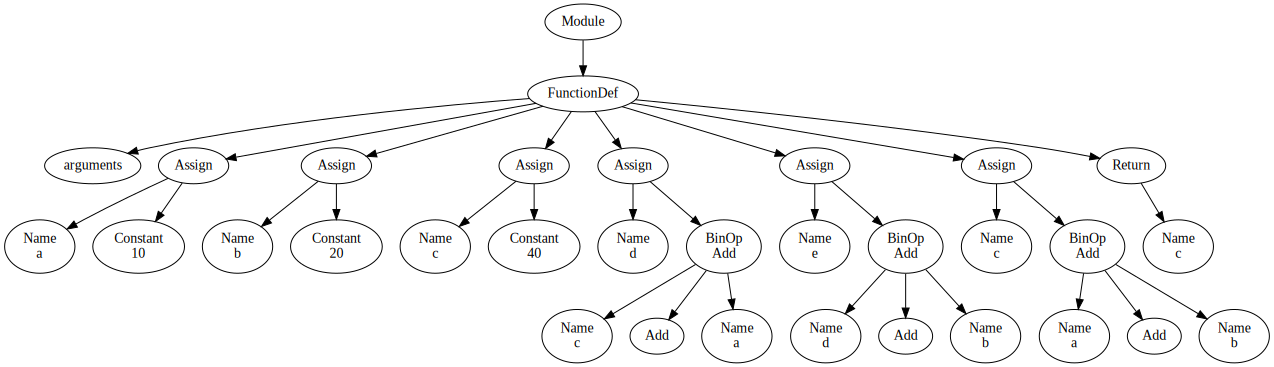

In [136]:
ast_from_ssa = ssa_to_ast(ssa_statements, dce_test)
ast_from_ssa_viz = visualize_ast(ast_from_ssa)
display(ast_from_ssa_viz)

AST Tree: Module(
    body=[
        FunctionDef(
            name='test_ast_loop',
            args=arguments(
                posonlyargs=[],
                args=[],
                kwonlyargs=[],
                kw_defaults=[],
                defaults=[]),
            body=[
                Assign(
                    targets=[
                        Name(id='x', ctx=Store())],
                    value=Constant(value=0)),
                For(
                    target=Name(id='i', ctx=Store()),
                    iter=Call(
                        func=Name(id='range', ctx=Load()),
                        args=[
                            Constant(value=0),
                            Constant(value=5)],
                        keywords=[]),
                    body=[
                        AugAssign(
                            target=Name(id='x', ctx=Store()),
                            op=Add(),
                            value=Name(id='i', ctx=Load()))],
              

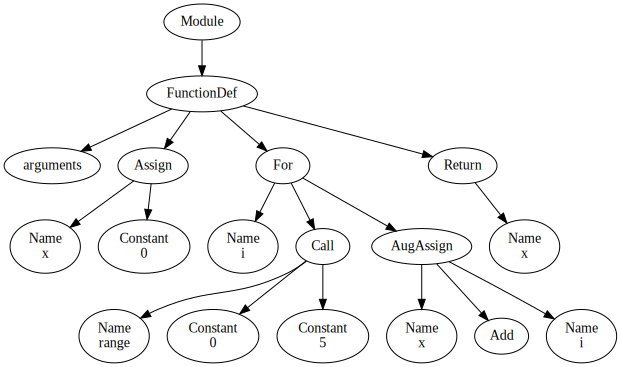

In [ ]:
# draw AST for a more complex function (involves loop)
# not SSA to AST

func_ast = get_ast(test_ast_loop)
ast_viz = visualize_ast(func_ast)
#ast_viz.render("AST Visualization", format="png", view=True)
display(ast_viz)